# Distributed PPO Anakin Agent using `flashbax` and `Jumanji`
### [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/instadeepai/flashbax/blob/main/examples/anakin_ppo_example.ipynb)

Adapted from [Gymnax Example](https://colab.research.google.com/github/RobertTLange/gymnax/blob/main/examples/01_anakin.ipynb) and DeepMind's [Example Colab](https://colab.research.google.com/drive/1974D-qP17fd5mLxy6QZv-ic4yxlPJp-G?usp=sharing#scrollTo=lhnJkrYLOvcs)

### Imports

In [ ]:
!git clone https://github.com/instadeepai/flashbax.git
!pip install ./flashbax[examples]

In [1]:
import flashbax as fbx

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import jax
from jax import lax
from jax import random
from jax import numpy as jnp
import jax.numpy as jnp
import haiku as hk
import optax
import rlax
import timeit
import distrax
import chex
from jumanji.wrappers import AutoResetWrapper
import jumanji

print("The following devices are available: ", jax.devices())

2023-09-26 14:48:50.362260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1695739731.729474 1499542 pjrt_api.cc:98] GetPjrtApi was found for tpu at /home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1695739731.729554 1499542 pjrt_api.cc:67] PJRT_Api is set for device type tpu
I0000 00:00:1695739731.729557 1499542 pjrt_api.cc:72] PJRT plugin for tpu has PJRT API version 0.30. The framework PJRT API version is 0.30.
I0000 00:00:1695739734.580817 1499542 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


The following devices are available:  [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


### Anakin PPO Distributed Agent Setup
The following is a simple PPO implementation in the Anakin framework.

In [3]:
@chex.dataclass(frozen=True)
class TimeStep:
    observation: chex.Array
    action: chex.Array
    discount: chex.Array
    reward: chex.Array
    behaviour_action_log_prob: chex.Array
    behaviour_value: chex.Array

@chex.dataclass(frozen=True)
class Params:
    online : hk.Params
    update_count : int

def get_network_fn(num_outputs: int):
    
    def network_fn(obs: chex.Array) -> chex.Array:
        x = hk.Sequential([
            hk.Conv2D(32, kernel_shape=2, stride=1),
            jax.nn.relu,
            hk.Conv2D(32, kernel_shape=2, stride=1),
            jax.nn.relu,
            hk.Flatten(),
            hk.Linear(256),
            jax.nn.relu])(obs)

        logits = hk.Sequential([
            hk.Flatten(),
            hk.Linear(128), 
            jax.nn.relu,
            hk.Linear(num_outputs)])(x)
        
        value = hk.Sequential([
            hk.Flatten(),
            hk.Linear(128), 
            jax.nn.relu,
            hk.Linear(1)])(x)

        return logits, value
    
    return hk.without_apply_rng(hk.transform(network_fn))

def get_learner_fn(
    env, forward_pass, buffer_fn, opt_update, rollout_len, agent_discount, iterations, gae_lambda, clip_epsilon, sgd_epochs):
    """Returns a learner function that can be used to train the parameters of the agent."""

    def rollout(params, outer_rng, env_state, env_timestep):
        """Collects a single trajectory from the environment."""

        def step_fn(env_data, rng):
            """A single step of the environment."""
            env_state, env_timestep, params = env_data
            obs_tm1 = env_timestep.observation.grid  
            d_tm1 = env_timestep.discount  
            a_logits_tm1, v_tm1 = forward_pass(params, jnp.expand_dims(obs_tm1, 0))  
            a_tm1_dist = distrax.Categorical(a_logits_tm1[0])
            a_tm1 = a_tm1_dist.sample(seed=rng) 
            a_tm1_log_prob = a_tm1_dist.log_prob(a_tm1)  
            new_env_state, new_env_timestep = env.step(env_state, a_tm1)
            r_t = new_env_timestep.reward 
          
            return (new_env_state, new_env_timestep, params), TimeStep( 
              observation = obs_tm1, action=a_tm1, discount=d_tm1, reward=r_t, behaviour_action_log_prob=a_tm1_log_prob, behaviour_value=v_tm1.squeeze())
              # We line up the observation with its discount, not the discount of the next observation as is usually seen.
              # This is so that we know in a transition that discount[1] is the discount of the next observation. 
              # e.g. indexing is v[t] = reward[t] + discount[t+1]*value[t+1]
              # Switching to Sutton and Barto's notation, we would have v[t] = reward[t+1] + discount[t+1]*value[t+1]
              # To do this, we would add r_tm1 = env_timestep.reward to the TimeStep dataclass, not the new_env_timestep.reward

        step_rngs = random.split(outer_rng, rollout_len)
        (env_state, env_timestep, params), rollout = lax.scan(step_fn, (env_state, env_timestep, params), step_rngs)  

        rollout = jax.tree.map(lambda x: jnp.expand_dims(x,0), rollout)
        
        return rollout, env_state, env_timestep
    
    def loss_fn(params : hk.Params, batch : TimeStep):
        """Computes the loss of the agent on a single trajectory."""
        
        logits_t, v_t = forward_pass(params, batch.observation)  
        a_log_prob_t = distrax.Categorical(logits_t).log_prob(batch.action.astype(jnp.int32)) 
        adv_t = rlax.truncated_generalized_advantage_estimation(batch.reward[:-1], batch.discount[1:] * agent_discount, gae_lambda, batch.behaviour_value, True) 
        rhos = jnp.exp(a_log_prob_t[:-1] - batch.behaviour_action_log_prob[:-1])
        pg_loss = rlax.clipped_surrogate_pg_loss(rhos, adv_t, clip_epsilon)
        entropy_loss = distrax.Categorical(logits_t).entropy()[:-1]
        target_values = batch.behaviour_value[:-1] + adv_t  
        value_loss = jnp.square(v_t[:-1] - target_values)
        loss = pg_loss + value_loss - 0.001*entropy_loss 
        loss = jnp.mean(loss)

        return loss

    def update_fn(params_state : Params, buffer_state, opt_state, rng, env_state, env_timestep):
        """Performs a rollout and updates the parameters of the agent."""

        rng, rollout_rng = random.split(rng)
        
        data_rollout, new_env_state, new_env_timestep = rollout(params_state.online, rollout_rng, env_state, env_timestep)  # collect trajectory.
        # The use of a queue here is not necessary since we push data in and immediately pop it out, but it is an example of how one could use it.
        # Note: we do not check can_add and can_sample here, but we could use jax.lax.cond to do so.
        # Branching slows down training and since we know for a fact that we can add and sample, we do not need to check.
        buffer_state = buffer_fn.add(buffer_state, data_rollout)  
        buffer_state, batch = buffer_fn.sample(buffer_state)  
        # We get rid of the batch dimension here
        batch = jax.tree.map(lambda x: jnp.squeeze(x, 0), batch.experience)  
        
        def epoch_update(carry, _):
            """Updates the parameters of the agent."""

            params, opt_state, batch = carry
            grads = jax.grad(  # compute gradient on a single trajectory.
                loss_fn)(params, batch)
            grads = lax.pmean(grads, axis_name='j')  # reduce mean across cores.
            grads = lax.pmean(grads, axis_name='i')  # reduce mean across batch.
            updates, new_opt_state = opt_update(grads, opt_state)  # transform grads.
            new_params = optax.apply_updates(params, updates)  # update parameters.
            return (new_params, new_opt_state, batch), None
        
        (new_params, new_opt_state, batch), _ = jax.lax.scan(epoch_update, (params_state.online, opt_state, batch), None, length=sgd_epochs)
        
        new_params_state = Params(online=new_params, update_count=params_state.update_count+1)
    
        return new_params_state, buffer_state, new_opt_state, rng, new_env_state, new_env_timestep

    def learner_fn(params_state : Params, buffer_state, opt_state, rngs, env_states, env_timesteps):
        """Performs multiple updates of the agent."""

        batched_update_fn = jax.vmap(update_fn, axis_name='j')  # vectorize across batch.
    
        def iterate_fn(_, val):  # repeat many times to avoid going back to Python.
            params_state, buffer_state, opt_state, rngs, env_states, env_timesteps = val
            return batched_update_fn(params_state, buffer_state, opt_state, rngs, env_states, env_timesteps)
        
        return lax.fori_loop(0, iterations, iterate_fn, (
            params_state, buffer_state, opt_state, rngs, env_states, env_timesteps))
    
       
    return learner_fn

### Create Experiment Fns

In [4]:
def set_up_experiment(env, rollout_len, step_size, seed, buffer_size):
    """Sets up the experiment and returns the necessary information."""

    cores_count = len(jax.devices())  # get available TPU cores.
    network = get_network_fn(env.action_spec.num_values)  # define network.
    optim = optax.adam(step_size)  # define optimiser.

    rng, rng_e, rng_p = random.split(random.PRNGKey(seed), num=3)  # prng keys.
    _, timestep = env.reset(rng_e)
    obs = timestep.observation.grid 
    dummy_obs = jnp.expand_dims(obs , 0) # dummy for net init.
    params = network.init(rng_p, dummy_obs)  # initialise params.
    opt_state = optim.init(params)  # initialise optimiser stats.
    buffer_fn = fbx.make_trajectory_queue(
        max_length_time_axis=buffer_size,
        add_batch_size=1,
        add_sequence_length=rollout_len,
        sample_sequence_length=rollout_len
    )
    dummy_transition = TimeStep(observation=obs,
                                action=jnp.zeros((), dtype=jnp.int32),
                                reward=timestep.reward,
                                discount=timestep.discount,
                                behaviour_action_log_prob=jnp.zeros(()),
                                behaviour_value=jnp.zeros(()),
                                )
    buffer_state = buffer_fn.init(dummy_transition) # initialise buffer.
    return cores_count, network, optim, params, opt_state, buffer_fn, buffer_state, rng


def get_rng_keys(cores_count, num_envs, rng):
    """Returns a list of rng keys for each environment."""
    rng, *step_rngs = jax.random.split(rng, cores_count * num_envs + 1)
    reshape = lambda x: x.reshape((cores_count, num_envs) + x.shape[1:])
    step_rngs = reshape(jnp.stack(step_rngs))  # add dimension to pmap over.
    return rng, step_rngs

def broadcast_to_device_shape(cores_count, num_envs, params, opt_state, buffer_state, rng):
    """Broadcasts the parameters to the shape of the device."""
    broadcast = lambda x: jnp.broadcast_to(x, (cores_count, num_envs) + x.shape)
    params = jax.tree.map(broadcast, params)  # broadcast to cores and batch.
    opt_state = jax.tree.map(broadcast, opt_state)  # broadcast to cores and batch
    buffer_state = jax.tree.map(broadcast, buffer_state)  # broadcast to cores and batch
    params_state = Params(online=params, update_count=jnp.zeros(shape=(cores_count, num_envs)))
    rng, step_rngs = get_rng_keys(cores_count, num_envs, rng)
    return params_state, opt_state, buffer_state, step_rngs, rng

### Create Environment

In [5]:
env = jumanji.make("Snake-v1", num_rows=6, num_cols=6)
training_env = AutoResetWrapper(env)

### Define Hyperparameters

In [6]:
# Number of Training-Evaluation iterations
TRAINING_EVAL_ITERS = 20

# Training parameters
LEARNING_RATE = 3e-4
SEED = 42
NUM_ENVS = 8
ROLLOUT_LEN = 64
BUFFER_SIZE = ROLLOUT_LEN
TRAINING_ITERS = 10
AGENT_DISCOUNT = 0.99
GAE_LAMBDA = 0.95
CLIP_EPSILON = 0.2
SGD_EPOCHS = 10

# Evaluation parameters
NUM_EVAL_EPISODES = 50

### Set Up Eval Fns

In [7]:

cores_count, network, optim, params, opt_state, buffer_fn, buffer_state, rng = set_up_experiment(
    env=training_env, 
    rollout_len=ROLLOUT_LEN, 
    step_size=LEARNING_RATE, 
    seed=SEED, 
    buffer_size=BUFFER_SIZE,)


@jax.jit
def eval_one_episode(params, rng):
    """Evaluates the agent on a single episode."""
    
    state, timestep = env.reset(rng)
    
    def step(val):
        params, state, timestep, tot_r, rng, done = val
        rng, key_step = jax.random.split(rng)
        obs = timestep.observation.grid
        a_logits_t, v_t = network.apply(params, obs[jnp.newaxis,])
        a_t = distrax.Categorical(a_logits_t).sample(seed=rng)[0]
        state, timestep = env.step(state, a_t)
        tot_r += timestep.reward
        return (params, state, timestep, tot_r, rng, timestep.last())
       
    params, state, timestep, tot_r, rng, done = jax.lax.while_loop(lambda val : val[5] == False, step, (params, state, timestep, 0, rng, False))

    return params, tot_r

@jax.jit
def eval(params, rng):
    """Evaluates the agent on multiple episodes."""

    rngs = random.split(rng, NUM_EVAL_EPISODES)
    params = jax.tree.map(lambda x: x[0][0], params)
    _, tot_r = jax.lax.scan(eval_one_episode, params, rngs)
    return tot_r.mean()

### Training the agent

In [8]:
rng, *env_rngs = jax.random.split(rng, cores_count * NUM_ENVS + 1)
env_states, env_timesteps = jax.vmap(env.reset)(jnp.stack(env_rngs))  # init envs.
reshape = lambda x: x.reshape((cores_count, NUM_ENVS) + x.shape[1:])
env_states = jax.tree.map(reshape, env_states)  # add dimension to pmap over.
env_timesteps = jax.tree.map(reshape, env_timesteps)  # add dimension to pmap over.
params_state, opt_state, buffer_state, step_rngs, rng = broadcast_to_device_shape(cores_count, NUM_ENVS, params, opt_state, buffer_state, rng)


learn = get_learner_fn(env=training_env, forward_pass=network.apply, buffer_fn=buffer_fn, opt_update=optim.update, rollout_len=ROLLOUT_LEN, agent_discount=AGENT_DISCOUNT, iterations=TRAINING_ITERS, gae_lambda=GAE_LAMBDA, clip_epsilon=CLIP_EPSILON, sgd_epochs=SGD_EPOCHS)
learn = jax.pmap(learn, axis_name='i')  # replicate over multiple cores.

avg_reward = []
total_time = 0
for training_eval_iters in range(1, TRAINING_EVAL_ITERS+1):
    # Train
    start = timeit.default_timer()
    params_state, buffer_state, opt_state, step_rngs, env_states, env_timesteps = learn(params_state, buffer_state, opt_state, step_rngs, env_states, env_timesteps)
    params_state = jax.tree.map(lambda x: x.block_until_ready(), params_state) # wait for params to be ready so time is accurate.
    total_time += timeit.default_timer() - start
    # Eval
    rng, eval_rng = jax.random.split(rng, num=2)
    tot_r = eval(params_state.online, eval_rng)
    avg_reward.append(tot_r)
    if training_eval_iters % 2 == 0:
        print(f"Average Reward at iteration {training_eval_iters}: {tot_r}")

Average Reward at iteration 2: 2.2799999713897705
Average Reward at iteration 4: 5.839999675750732
Average Reward at iteration 6: 10.579999923706055
Average Reward at iteration 8: 14.239999771118164
Average Reward at iteration 10: 15.319999694824219
Average Reward at iteration 12: 16.53999900817871
Average Reward at iteration 14: 16.920000076293945
Average Reward at iteration 16: 18.239999771118164
Average Reward at iteration 18: 17.19999885559082
Average Reward at iteration 20: 16.8799991607666


### Plotting the reward

/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/e.toledo/miniconda3/envs/flashbax/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

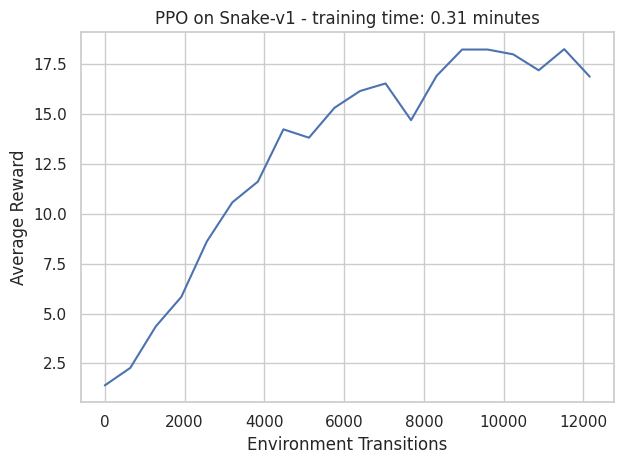

In [9]:
%matplotlib inline
sns.set(style="whitegrid")

num_env_transitions = ROLLOUT_LEN*TRAINING_ITERS*TRAINING_EVAL_ITERS
x_values = np.asarray(jnp.arange(0, num_env_transitions, num_env_transitions/len(avg_reward)))
avg_reward = np.asarray(avg_reward)

sns.lineplot(x=x_values, y=avg_reward)
plt.xlabel('Environment Transitions')
plt.ylabel('Average Reward')
plt.title(f'PPO on Snake-v1 - training time: {np.round((total_time)/60, 2)} minutes')

plt.tight_layout()
plt.show()